# Exercise Solution: Explainable AI (LOS Dataset)

If using colab, run this cell first. Otherwise, skip this cell.

In [ ]:
!pip install catboost
!pip install --upgrade scikit-learn
!git clone https://github.com/hsma-programme/h6_4g_explainable_ai.git
%cd /content/h6_4g_explainable_ai/solutions

## Core

We're going to work with a dataset to try to predict patient length of stay. 

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import the relevant models from Sklearn, XGBoost, CatBoost and LightGBM
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
# import any other libraries you need
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, \
                            r2_score, root_mean_squared_error


In [70]:
# Additional imports for explainable AI
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Import shap for shapley values
import shap

# JavaScript Important for the interactive charts later on
shap.initjs()

Open the data dictionary in the los_dataset folder and take a look at what data is available.

Next, load in the dataframe containing the LOS data.

In [71]:
los_df = pd.read_csv("../datasets/los_dataset/LengthOfStay.csv", index_col="eid")

View the dataframe.

In [72]:
los_df.head()

vdate rcount gender  dialysisrenalendstage  asthma  irondef  pneum  \
eid                                                                            
1     8/29/2012      0      F                      0       0        0      0   
2     5/26/2012     5+      F                      0       0        0      0   
3     9/22/2012      1      F                      0       0        0      0   
4      8/9/2012      0      F                      0       0        0      0   
5    12/20/2012      0      F                      0       0        0      1   

     substancedependence  psychologicaldisordermajor  depress  ...  \
eid                                                            ...   
1                      0                           0        0  ...   
2                      0                           0        0  ...   
3                      0                           0        0  ...   
4                      0                           0        0  ...   
5                      0                           1        0  ...   

         sodium     glucose  bloodureanitro  creatinine        bmi  pulse  \
eid                                                                         
1    140.361132  192.476918            12.0    1.390722  30.432418     96   
2    136.731692   94.078507             8.0    0.943164  28.460516     61   
3    133.058514  130.530524            12.0    1.065750  28.843812     64   
4    138.994023  163.377028            12.0    0.906862  27.959007     76   
5    138.634836   94.886654            11.5    1.242854  30.258927     67   

     respiration  secondarydiagnosisnonicd9  facid  lengthofstay  
eid                                                               
1            6.5                          4      B             3  
2            6.5                          1      A             7  
3            6.5                          2      B             3  
4            6.5                          1      A             1  
5            5.6                          2      E             4  

[5 rows x 26 columns]

Consider what columns to remove. 

HINT: Is there a column in the dataset that doesn't really make much sense to predict from? 
If you're not sure, use the full dataset for now and come back to this later.

NOTE: For now, we're going to assume that all of the included measures will be available to us at the point we need to make a prediction - they're not things that will be calculated later in the patient's stay.

In [73]:
los_df = los_df.drop(columns="vdate")
los_df.head(1)

rcount gender  dialysisrenalendstage  asthma  irondef  pneum  \
eid                                                                
1        0      F                      0       0        0      0   

     substancedependence  psychologicaldisordermajor  depress  psychother  \
eid                                                                         
1                      0                           0        0           0   

     ...      sodium     glucose  bloodureanitro  creatinine        bmi  \
eid  ...                                                                  
1    ...  140.361132  192.476918            12.0    1.390722  30.432418   

     pulse  respiration  secondarydiagnosisnonicd9  facid  lengthofstay  
eid                                                                      
1       96          6.5                          4      B             3  

[1 rows x 25 columns]

Convert categories with only two options into a boolean value (e.g. for a gender column in which gender has only been provided as M or F, you could encode M as 0 and F as 1).

In [74]:
los_df.gender.unique()

array(['F', 'M'], dtype=object)

In [75]:
los_df['gender'].replace('M', 0, inplace=True)
los_df['gender'].replace('F', 1, inplace=True)

los_df.gender.unique()

array([1, 0], dtype=int64)

Convert columns with multiple options per category into multiple columns using one-hot encoding. 

In [76]:
los_df.facid.unique()

# Bonus - astype('int') will convert the true/false values to 0/1
# not necessary - it will work regardless
one_hot = pd.get_dummies(los_df['facid']).astype('int')
los_df = los_df.drop('facid', axis=1)
los_df = los_df.join(one_hot)

In [77]:
los_df.head()

rcount  gender  dialysisrenalendstage  asthma  irondef  pneum  \
eid                                                                 
1        0       1                      0       0        0      0   
2       5+       1                      0       0        0      0   
3        1       1                      0       0        0      0   
4        0       1                      0       0        0      0   
5        0       1                      0       0        0      1   

     substancedependence  psychologicaldisordermajor  depress  psychother  \
eid                                                                         
1                      0                           0        0           0   
2                      0                           0        0           0   
3                      0                           0        0           0   
4                      0                           0        0           0   
5                      0                           1        0           0   

     ...        bmi  pulse  respiration  secondarydiagnosisnonicd9  \
eid  ...                                                             
1    ...  30.432418     96          6.5                          4   
2    ...  28.460516     61          6.5                          1   
3    ...  28.843812     64          6.5                          2   
4    ...  27.959007     76          6.5                          1   
5    ...  30.258927     67          5.6                          2   

     lengthofstay  A  B  C  D  E  
eid                               
1               3  0  1  0  0  0  
2               7  1  0  0  0  0  
3               3  0  1  0  0  0  
4               1  1  0  0  0  0  
5               4  0  0  0  0  1  

[5 rows x 29 columns]

In [78]:
los_df.rcount.value_counts()

# Bonus - astype('int') will convert the true/false values to 0/1
# not necessary - it will work regardless
one_hot = pd.get_dummies(los_df['rcount'], prefix="rcount").astype('int')
los_df = los_df.drop('rcount', axis=1)
los_df = los_df.join(one_hot)
los_df.head()

gender  dialysisrenalendstage  asthma  irondef  pneum  \
eid                                                          
1         1                      0       0        0      0   
2         1                      0       0        0      0   
3         1                      0       0        0      0   
4         1                      0       0        0      0   
5         1                      0       0        0      1   

     substancedependence  psychologicaldisordermajor  depress  psychother  \
eid                                                                         
1                      0                           0        0           0   
2                      0                           0        0           0   
3                      0                           0        0           0   
4                      0                           0        0           0   
5                      0                           1        0           0   

     fibrosisandother  ...  B  C  D  E  rcount_0  rcount_1  rcount_2  \
eid                    ...                                             
1                   0  ...  1  0  0  0         1         0         0   
2                   0  ...  0  0  0  0         0         0         0   
3                   0  ...  1  0  0  0         0         1         0   
4                   0  ...  0  0  0  0         1         0         0   
5                   0  ...  0  0  0  1         1         0         0   

     rcount_3  rcount_4  rcount_5+  
eid                                 
1           0         0          0  
2           0         0          1  
3           0         0          0  
4           0         0          0  
5           0         0          0  

[5 rows x 34 columns]

Train a decision tree model to predict length of stay based on the variables in this dataset. 

In [79]:
X = los_df.drop(columns='lengthofstay')
y = los_df['lengthofstay']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state=42
    )

regr_dt = DecisionTreeRegressor(random_state=42)

# Train the model using the training sets
regr_dt.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_train = regr_dt.predict(X_train)
y_pred_test = regr_dt.predict(X_test)


In [80]:
y_pred_test

array([3., 1., 3., ..., 8., 2., 5.])

Assess the performance of this model.

In [81]:
print("TRAINING DATA")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_train, y_pred_train):.2%}" )
print("Root Mean squared error: %.2f" % root_mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred_train))

TRAINING DATA
Mean absolute error: 0.00
Mean absolute percentage error: 0.00%
Root Mean squared error: 0.00
Coefficient of determination: 1.00


In [82]:
print("TESTING DATA")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred_test):.2%}" )
print("Root Mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred_test))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

TESTING DATA
Mean absolute error: 0.50
Mean absolute percentage error: 12.94%
Root Mean squared error: 0.93
Coefficient of determination: 0.84


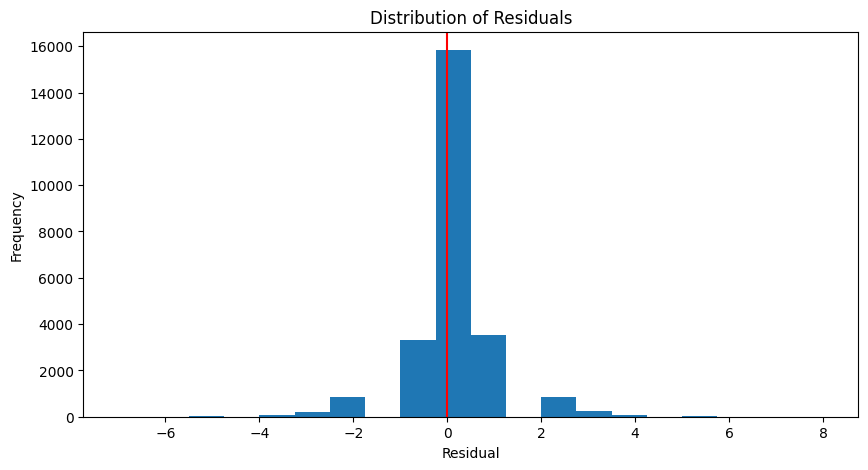

In [83]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted

    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=20)
    plt.axvline(x = 0, color = 'r')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

plot_residuals(y_test, y_pred_test)

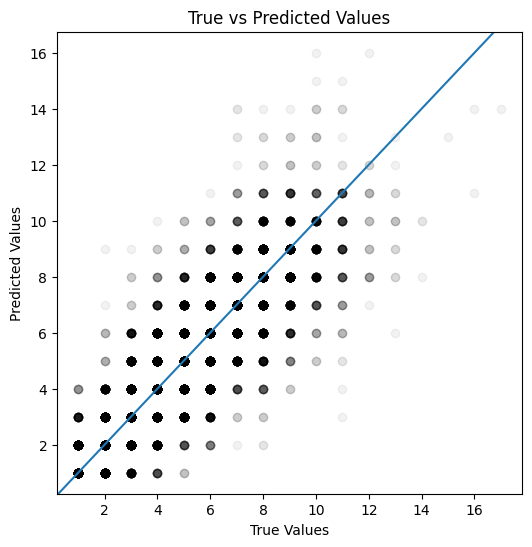

In [84]:
def plot_actual_vs_predicted(actual, predicted):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(actual, predicted, color="black", alpha=0.05)
    ax.axline((1, 1), slope=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_test)

Train a boosting model to predict length of stay based on the variables in this dataset.

In [85]:
X = los_df.drop(columns='lengthofstay')
y = los_df['lengthofstay']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state=42
    )

regr_xgb = XGBRegressor(random_state=42)

# Train the model using the training sets
regr_xgb.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_train = regr_xgb.predict(X_train)
y_pred_test = regr_xgb.predict(X_test)


In [86]:
y_pred_test

array([3.6313417, 0.8304186, 2.4800673, ..., 5.5354204, 1.5881324,
       5.249632 ], dtype=float32)

Assess the performance of this model and compare it with your decision tree model. 

In [87]:
print("TRAINING DATA")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_train, y_pred_train):.2%}" )
print("Root Mean squared error: %.2f" % root_mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred_train))

TRAINING DATA
Mean absolute error: 0.29
Mean absolute percentage error: 10.66%
Root Mean squared error: 0.37
Coefficient of determination: 0.98


In [88]:
print("TESTING DATA")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred_test):.2%}" )
print("Root Mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred_test))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

TESTING DATA
Mean absolute error: 0.33
Mean absolute percentage error: 11.60%
Root Mean squared error: 0.44
Coefficient of determination: 0.96


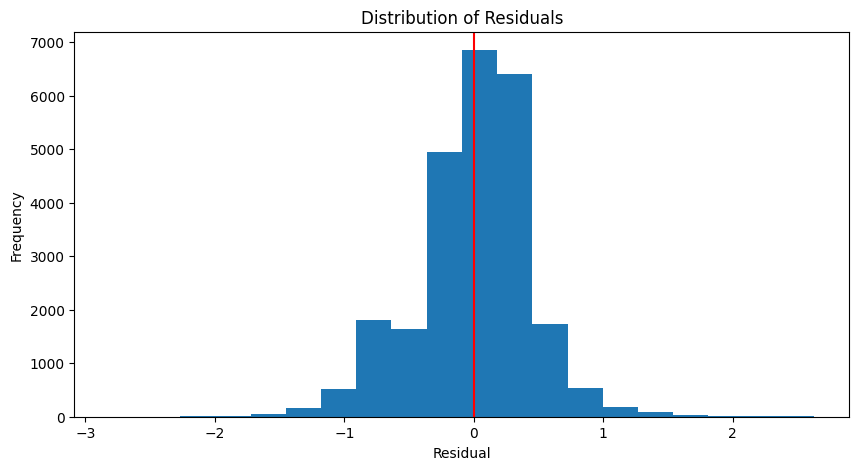

In [89]:
plot_residuals(y_test, y_pred_test)

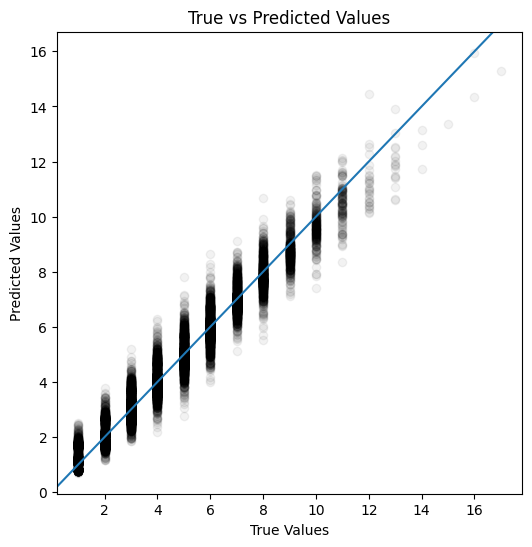

In [90]:
plot_actual_vs_predicted(y_test, y_pred_test)

## Exercise 4G: Explainable AI

### Explore feature importance

#### Importance with MDI

In [91]:
features = list(X_train)

feature_importances_dt = regr_dt.feature_importances_
importances_dt = pd.DataFrame(index=features)
importances_dt['importance_dt'] = feature_importances_dt
importances_dt['rank_dt'] = importances_dt['importance_dt'].rank(ascending=False).values
importances_dt.sort_values('rank_dt').head()

importance_dt  rank_dt
rcount_0         0.358057      1.0
rcount_1         0.140998      2.0
E                0.114736      3.0
hematocrit       0.044496      4.0
rcount_2         0.040130      5.0

In [92]:
feature_importances_xgb = regr_xgb.feature_importances_
importances_xgb = pd.DataFrame(index=features)
importances_xgb['importance_xgb'] = feature_importances_xgb
importances_xgb['rank_xgb'] = importances_xgb['importance_xgb'].rank(ascending=False).values
importances_xgb.sort_values('rank_xgb').head()

importance_xgb  rank_xgb
rcount_0        0.298638       1.0
rcount_1        0.223313       2.0
E               0.104948       3.0
rcount_2        0.095113       4.0
rcount_3        0.044833       5.0

### Repeat using PFI

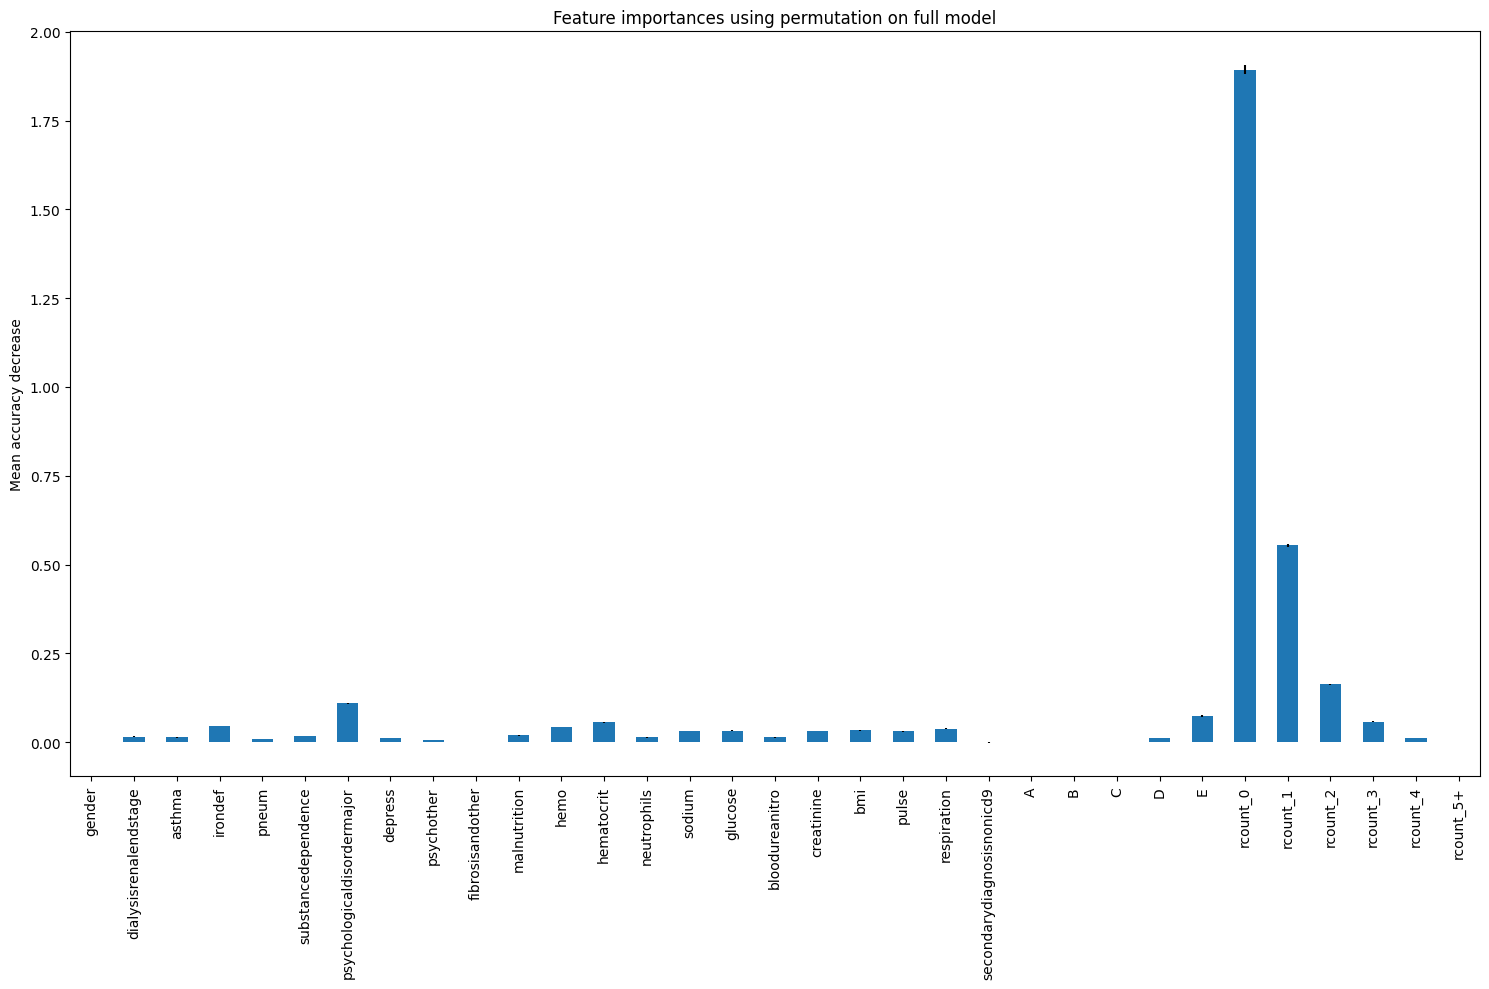

In [93]:
feature_names = X.columns.tolist()

result_dt_pfi = permutation_importance(
    regr_dt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

importances_pfi_dt = pd.Series(result_dt_pfi.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
importances_pfi_dt.plot.bar(yerr=result_dt_pfi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

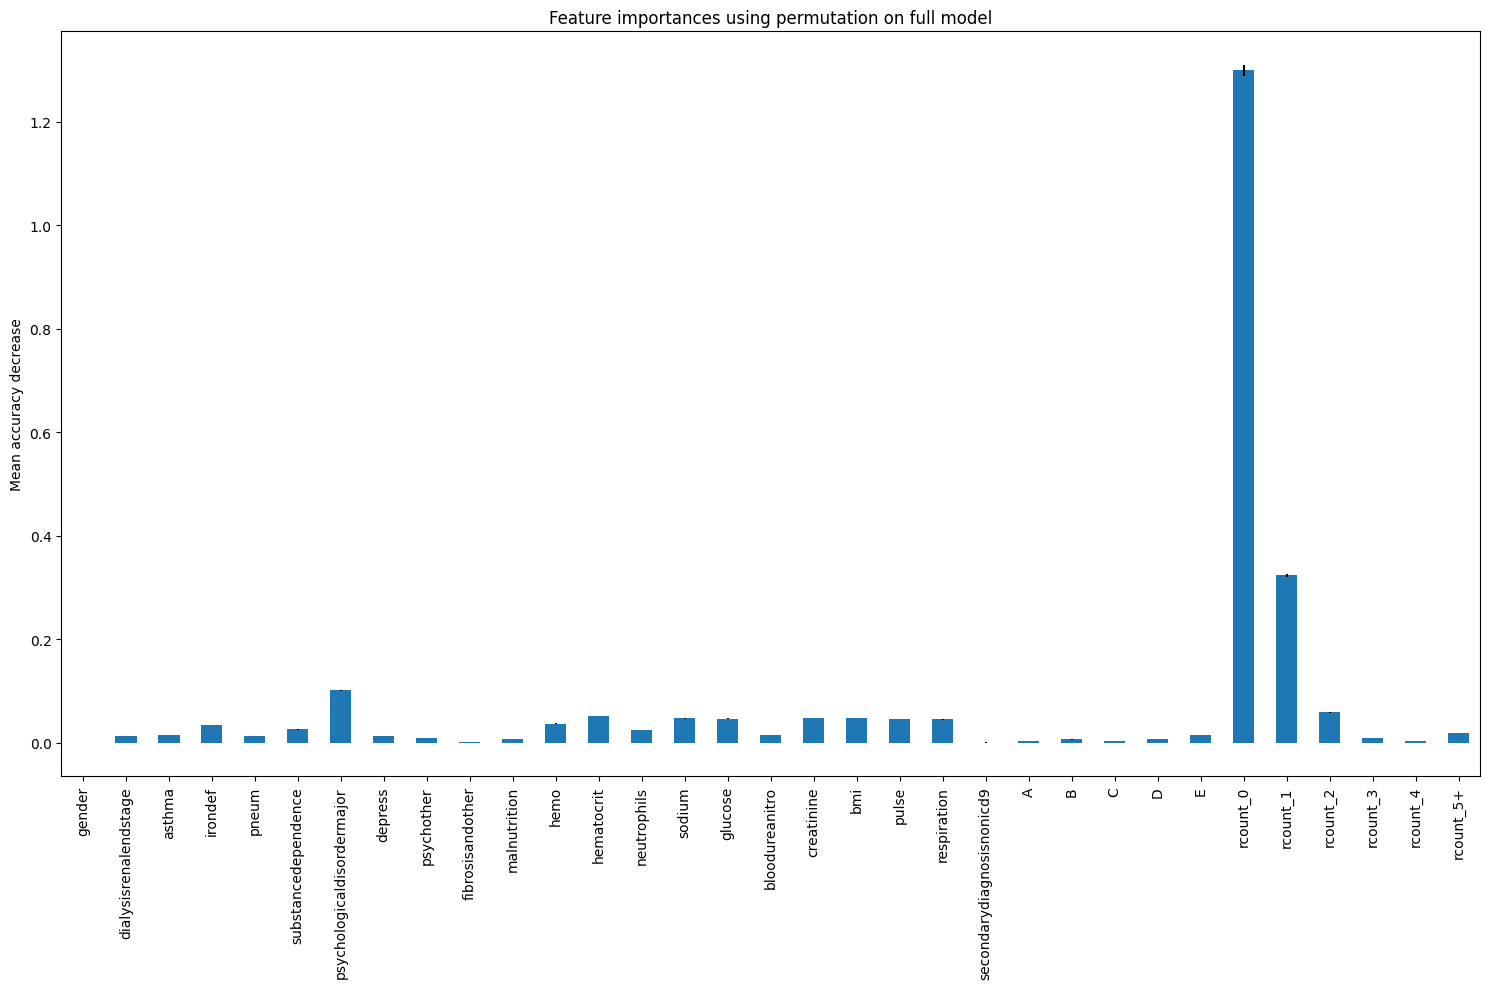

In [94]:
feature_names = X.columns.tolist()

result_xgb_pfi = permutation_importance(
    regr_xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

importances_pfi_xgb = pd.Series(result_xgb_pfi.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
importances_pfi_xgb.plot.bar(yerr=result_xgb_pfi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## SHAP

All code below has just been applied to the xg boost version of the model.

When do we pass in different bits of data? 

>The foreground data is the input to explainer.shap_values and the background data is the data parameter of shap.TreeExplainer's __init__.
>
>If you don't input foreground data you won't get SHAP values, so it wouldn't make much sense to not input foreground data.
>
>If you don't input the background data, it will actually use a different version of TreeExplainer (path dependent) that implicitly uses the training data as the background data set.

- Hugh Chen, https://github.com/shap/shap/issues/1366

In [95]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(regr_xgb, X_train)

shap_values = explainer(X_test)

shap_values

 99%|===================| 24754/25000 [00:49<00:00]        

.values =
array([[ 0.00764417,  0.        , -0.03838515, ...,  0.02178417,
        -0.01230581, -0.05431815],
       [ 0.00406493,  0.        , -0.08355626, ...,  0.02667989,
        -0.01247949, -0.05238643],
       [-0.00260847,  0.        , -0.07398675, ...,  0.02891657,
        -0.01341456, -0.05173721],
       ...,
       [-0.00061298,  0.        , -0.03833514, ...,  0.02290138,
        -0.0153973 , -0.05772406],
       [-0.00180168,  0.        , -0.06790128, ...,  0.02414472,
        -0.01215895, -0.05733014],
       [ 0.00211131,  0.        , -0.04626162, ...,  0.02808055,
        -0.00878728, -0.045735  ]])

.base_values =
array([3.79460651, 3.79460651, 3.79460651, ..., 3.79460651, 3.79460651,
       3.79460651])

.data =
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Returning just the values

It can be useful to have access to just the shap values in an object as they are required as the input to some steps.

Note that we have used 'shap_values' as the variable to store the output of  `explainer()`. So we will need to give it another name! 

In [96]:
shap_values_numeric = shap_values.values
shap_values_numeric

array([[ 0.00764417,  0.        , -0.03838515, ...,  0.02178417,
        -0.01230581, -0.05431815],
       [ 0.00406493,  0.        , -0.08355626, ...,  0.02667989,
        -0.01247949, -0.05238643],
       [-0.00260847,  0.        , -0.07398675, ...,  0.02891657,
        -0.01341456, -0.05173721],
       ...,
       [-0.00061298,  0.        , -0.03833514, ...,  0.02290138,
        -0.0153973 , -0.05772406],
       [-0.00180168,  0.        , -0.06790128, ...,  0.02414472,
        -0.01215895, -0.05733014],
       [ 0.00211131,  0.        , -0.04626162, ...,  0.02808055,
        -0.00878728, -0.045735  ]])

#### Feature Table

In [97]:
# get feature importance for comparison using MDI method
features = list(X_train)
feature_importances = regr_xgb.feature_importances_
importances = pd.DataFrame(index=features)
importances['importance'] = feature_importances
importances['rank'] = importances['importance'].rank(ascending=False).values
importances.sort_values('rank').head()

# Get shapley importances
# Calculate mean Shapley value for each feature in trainign set
importances['mean_shapley_values'] = np.mean(
    shap_values_numeric, axis=0
    )

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
importances['mean_abs_shapley_values'] = np.mean(
    np.abs(shap_values_numeric), axis=0
    )

importances


importance  rank  mean_shapley_values  \
gender                        0.000152  33.0             0.000497   
dialysisrenalendstage         0.004975  23.0             0.022847   
asthma                        0.004017  25.0            -0.029080   
irondef                       0.016412   9.0            -0.016085   
pneum                         0.006473  16.0             0.027612   
substancedependence           0.005187  19.0            -0.031714   
psychologicaldisordermajor    0.014801  10.0             0.014358   
depress                       0.002699  28.0            -0.025356   
psychother                    0.001460  29.0             0.009927   
fibrosisandother              0.002701  27.0            -0.001231   
malnutrition                  0.005148  20.0             0.012160   
hemo                          0.020425   8.0            -0.007621   
hematocrit                    0.008906  12.0             0.027616   
neutrophils                   0.003719  26.0             0.006639   
sodium                        0.005029  21.0             0.018857   
glucose                       0.005008  22.0             0.052205   
bloodureanitro                0.007172  15.0             0.038006   
creatinine                    0.004722  24.0            -0.030582   
bmi                           0.005255  18.0             0.033641   
pulse                         0.006221  17.0            -0.011668   
respiration                   0.008615  13.0             0.003487   
secondarydiagnosisnonicd9     0.000228  32.0             0.000217   
A                             0.001182  30.0            -0.005640   
B                             0.000977  31.0            -0.003409   
C                             0.008053  14.0            -0.006742   
D                             0.028479   7.0            -0.000704   
E                             0.104948   3.0            -0.001272   
rcount_0                      0.298638   1.0             0.142340   
rcount_1                      0.223313   2.0            -0.021455   
rcount_2                      0.095113   4.0            -0.020626   
rcount_3                      0.044833   5.0            -0.003072   
rcount_4                      0.014782  11.0             0.007687   
rcount_5+                     0.040360   6.0            -0.015835   

                            mean_abs_shapley_values  
gender                                     0.003516  
dialysisrenalendstage                      0.022847  
asthma                                     0.084459  
irondef                                    0.134217  
pneum                                      0.027612  
substancedependence                        0.132673  
psychologicaldisordermajor                 0.361950  
depress                                    0.082002  
psychother                                 0.046745  
fibrosisandother                           0.006100  
malnutrition                               0.029192  
hemo                                       0.122109  
hematocrit                                 0.265825  
neutrophils                                0.125201  
sodium                                     0.254019  
glucose                                    0.235265  
bloodureanitro                             0.056848  
creatinine                                 0.275831  
bmi                                        0.254814  
pulse                                      0.261527  
respiration                                0.236613  
secondarydiagnosisnonicd9                  0.002621  
A                                          0.031220  
B                                          0.042982  
C                                          0.026159  
D                                          0.021886  
E                                          0.065105  
rcount_0                                   1.741959  
rcount_1                                   0.514860  
rcount_2                                   0.171157  
rcount_

In [98]:
importance_top_10 = \
    importances.sort_values(
        by='importance', ascending=False
        ).head(10).index

shapley_top_10 = \
    importances.sort_values(
        by='mean_abs_shapley_values',
        ascending=False).head(10).index

# Add to DataFrame
top_10_features = pd.DataFrame()
top_10_features['importances'] = importance_top_10.values
top_10_features['Shapley'] = shapley_top_10.values

# Display
top_10_features

importances                     Shapley
0                    rcount_0                    rcount_0
1                    rcount_1                    rcount_1
2                           E  psychologicaldisordermajor
3                    rcount_2                  creatinine
4                    rcount_3                  hematocrit
5                   rcount_5+                       pulse
6                           D                         bmi
7                        hemo                      sodium
8                     irondef                 respiration
9  psychologicaldisordermajor                     glucose

### Global: Beeswarm

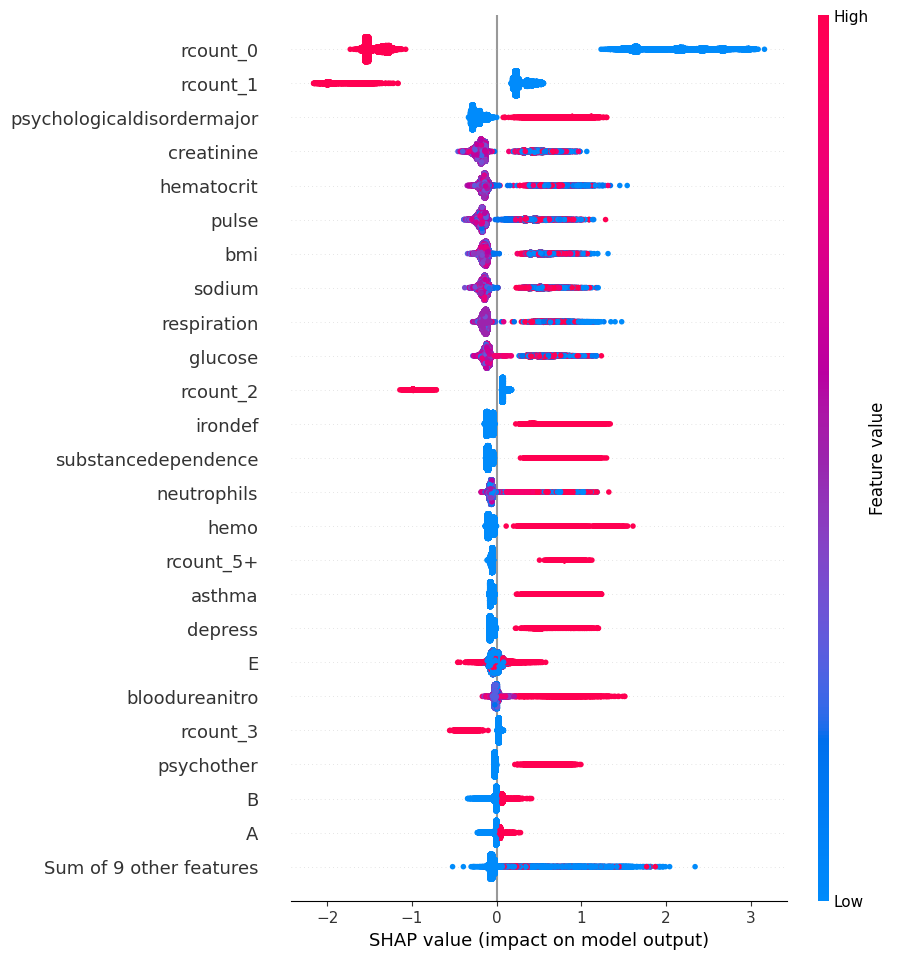

In [99]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=25)

### Global: Bar

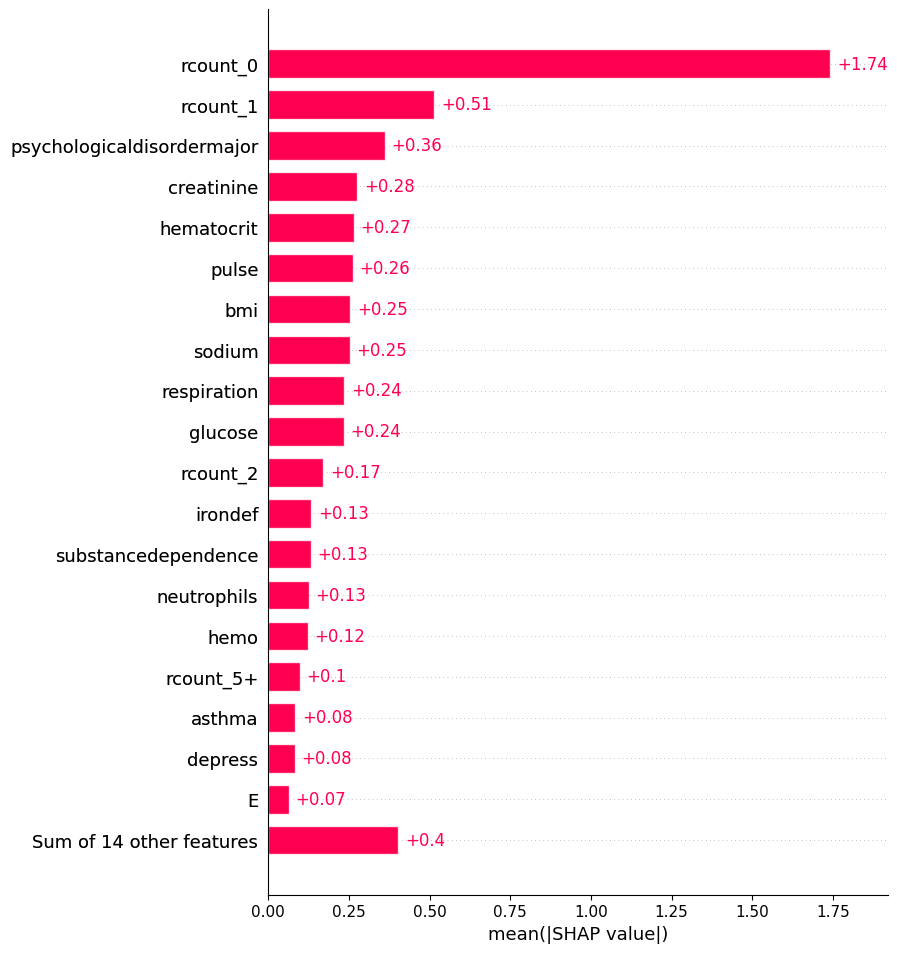

In [100]:
shap.plots.bar(shap_values, max_display=20)

#### Bar: by another factor

Here we are creating a bar chart by another cohort.

We can see there is almost no gender difference in this dataset.

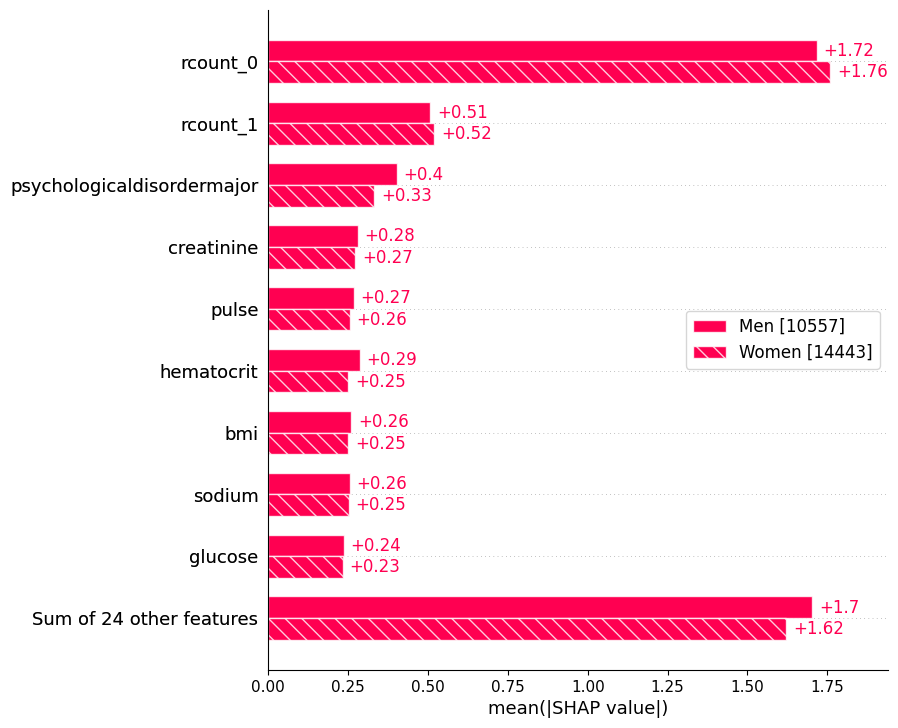

In [101]:
sex = ["Women" if shap_values[i, "gender"].data == 1 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

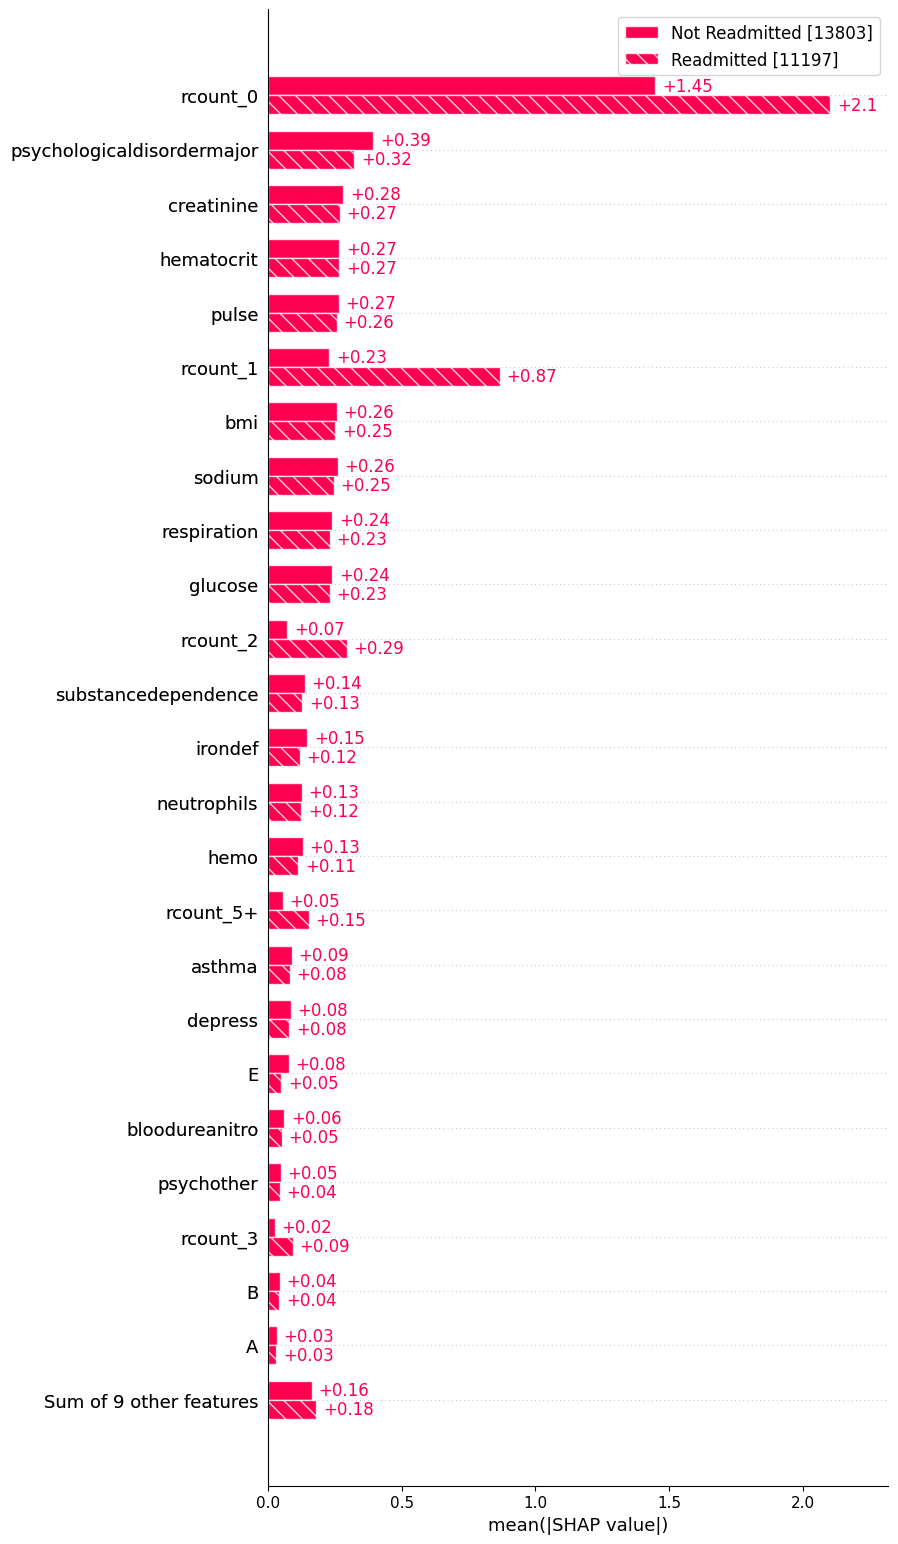

In [102]:
readmission_status = ["Not Readmitted" if shap_values[i, "rcount_0"].data == 1 else "Readmitted" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(readmission_status).abs.mean(0), max_display=25)

### Local: Waterfall Plots

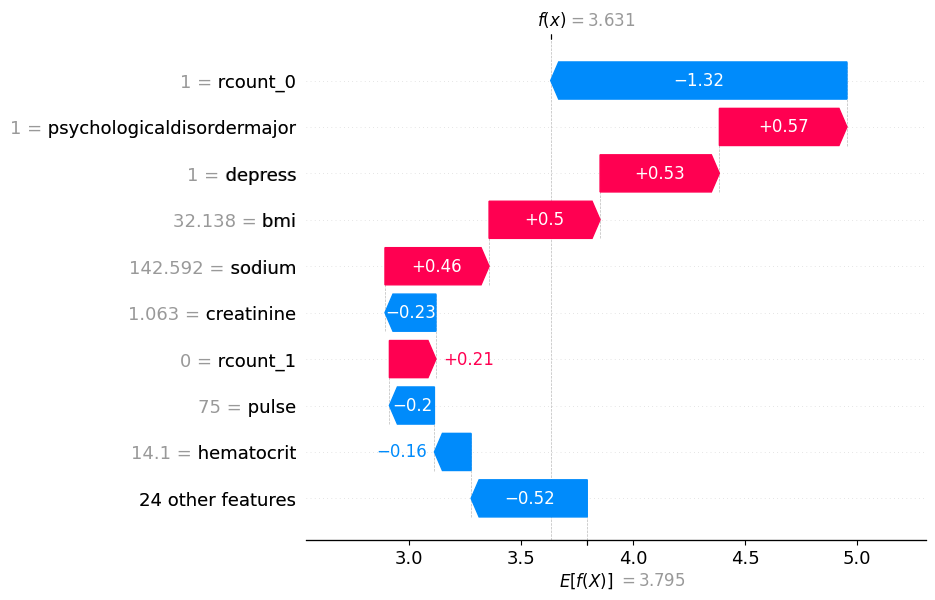

In [103]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

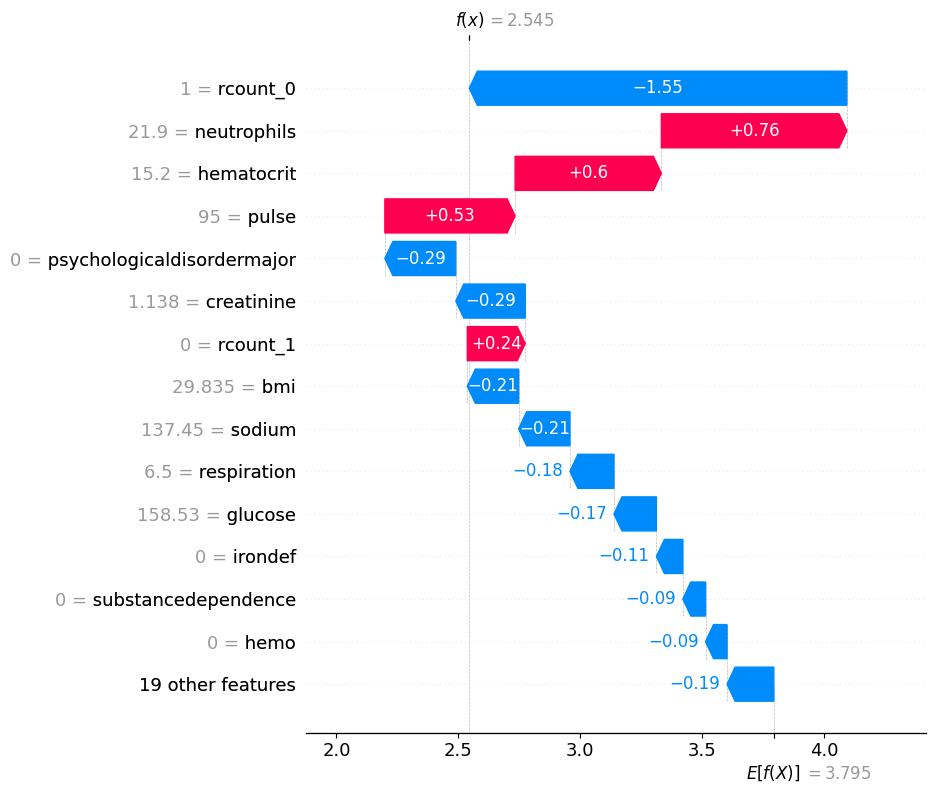

In [104]:
# visualize another prediction's explanation
shap.plots.waterfall(shap_values[7], max_display=15)

#### Visualise an example with a high LoS


In [105]:
highest_los = los_df.sort_values('lengthofstay', ascending=False).head(1)

high_los_index = highest_los.index
highest_los.lengthofstay

eid
7493    17
Name: lengthofstay, dtype: int64

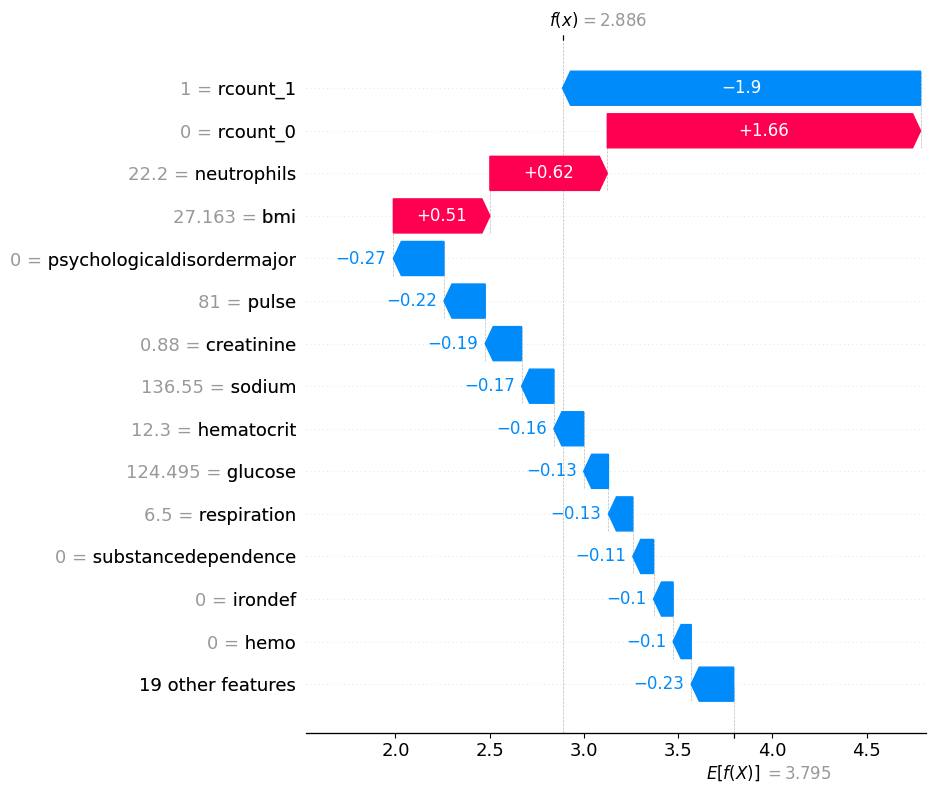

In [106]:
shap.plots.waterfall(shap_values[7493], max_display=15)

#### Visualise an example with a low LoS

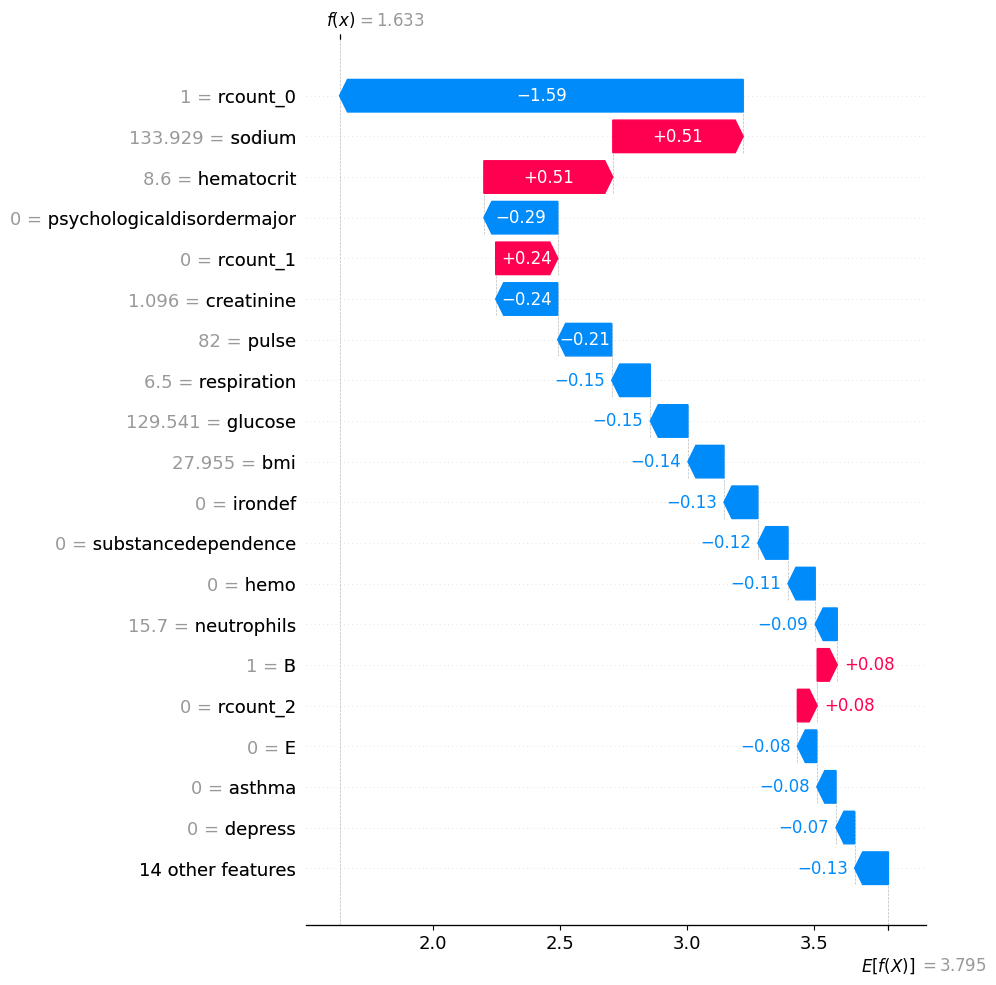

In [137]:
shap.plots.waterfall(shap_values[y_test.reset_index(drop=True).sort_values().head(1).index[0]], max_display=20)

#### Visualise an example with a high LoS

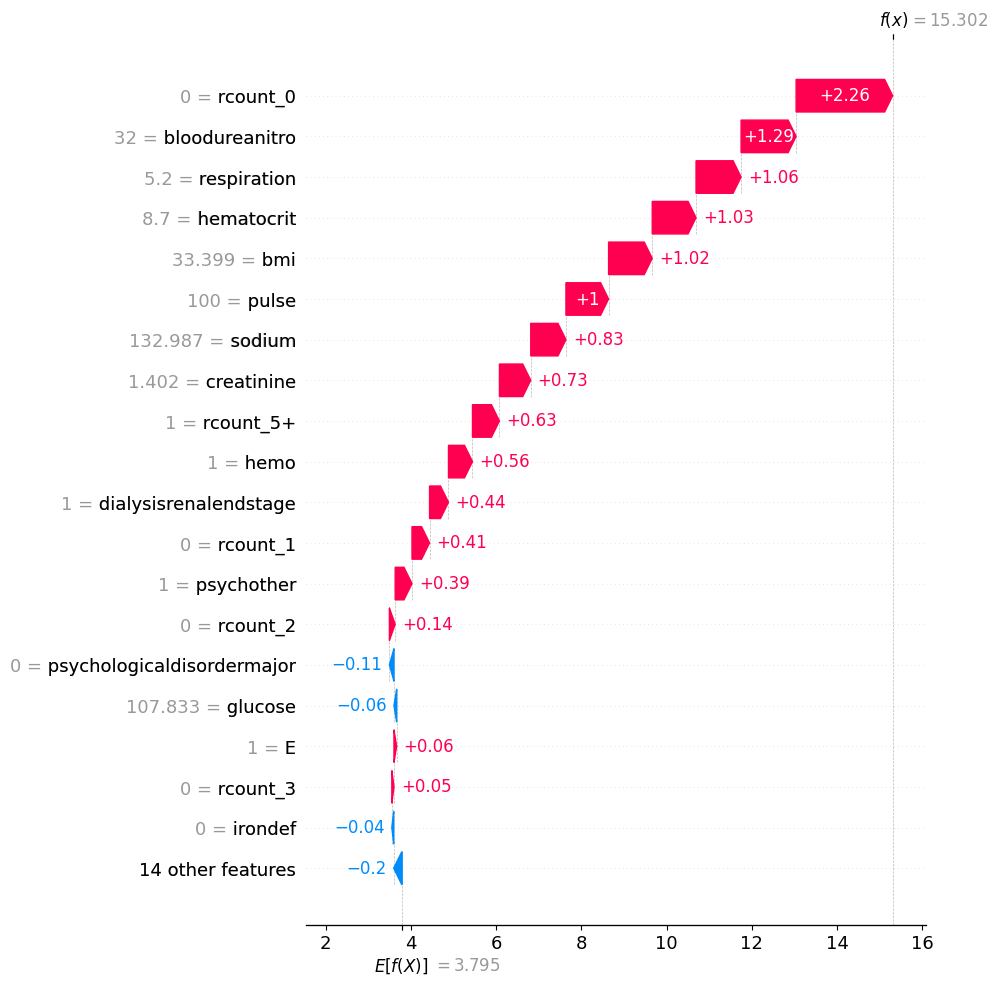

In [138]:
shap.plots.waterfall(shap_values[y_test.reset_index(drop=True).sort_values().tail(1).index[0]], max_display=20)

### Local: Force Plots

In [139]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [142]:
shap.plots.force(shap_values[y_test.reset_index(drop=True).sort_values().head(1).index[0]])

In [143]:
shap.plots.force(shap_values[y_test.reset_index(drop=True).sort_values().tail(1).index[0]])

0        3.631342
1        0.830419
2        2.480067
3        1.077456
4        5.112955
           ...   
24995    7.090035
24996    1.122499
24997    5.535420
24998    1.588132
24999    5.249632
Length: 25000, dtype: float32

#### Visualise the lowest predicted LoS

In [148]:
shap.plots.force(shap_values[pd.Series(y_pred_test).sort_values().head(1).index[0]])

#### Visualise the highest predicted LoS

In [149]:
shap.plots.force(shap_values[pd.Series(y_pred_test).sort_values().tail(1).index[0]])

### Global: Force Plots

In [150]:
# visualize all the predictions
# this struggles with a large number of values so we'll sample a small set
shap.plots.force(shap.utils.sample(shap_values, 1000))

### Dependence Plots

#### Simple scatter of a single feature

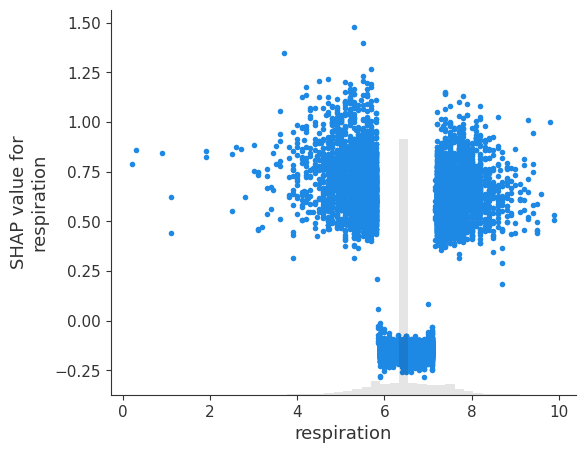

In [43]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, 'respiration'])

### Scatter of multiple features 

Passing in shap_values to the colour will colour the value by the most strongly interacting other value.

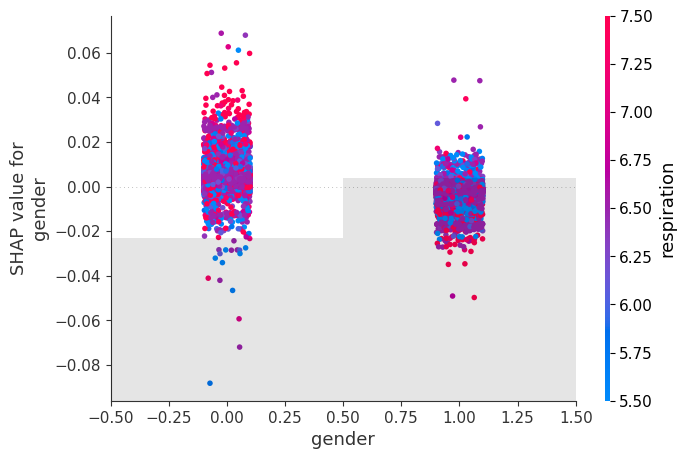

In [44]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "gender"], color=shap_values)

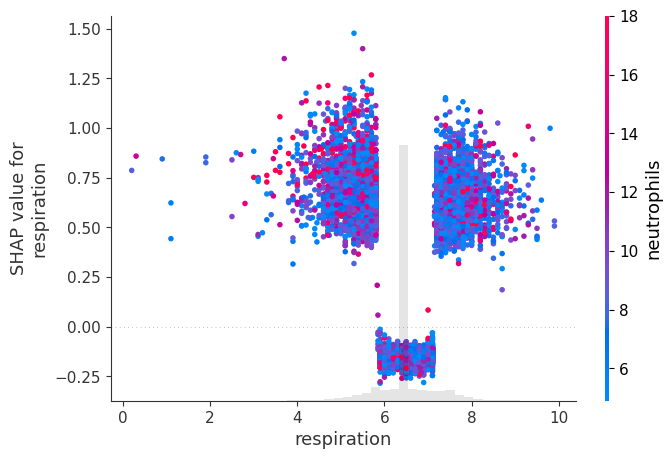

In [45]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "respiration"], color=shap_values)

Alternatively we can choose to colour by a specific column.

In [46]:
X.columns

Index(['gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum',
       'substancedependence', 'psychologicaldisordermajor', 'depress',
       'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit',
       'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine',
       'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'A', 'B',
       'C', 'D', 'E', 'rcount_0', 'rcount_1', 'rcount_2', 'rcount_3',
       'rcount_4', 'rcount_5+'],
      dtype='object')

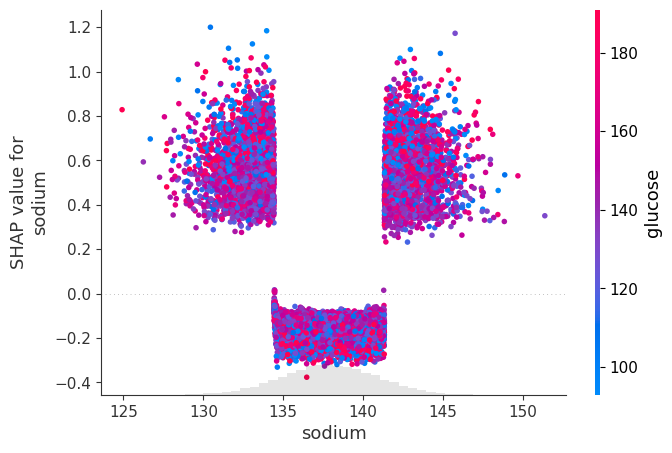

In [47]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "sodium"], color=shap_values[:,"glucose"])

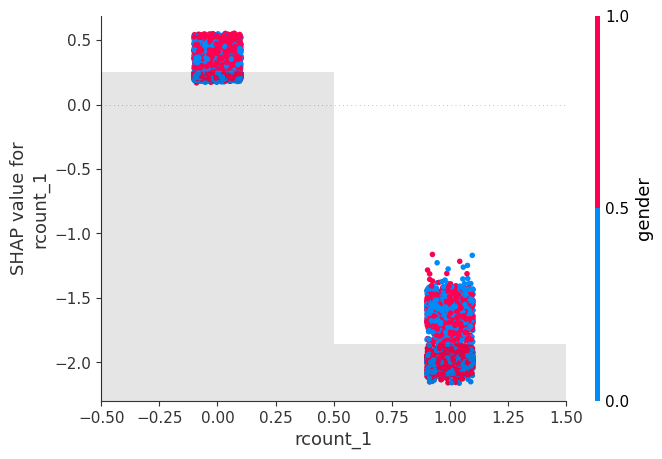

In [48]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "rcount_1"], color=shap_values[:,"gender"])

### BONUS: SHAP interactions

Full details of SHAP interactions can be found here: https://michaelallen1966.github.io/titanic/90_shap_interactions_on_titanic.html

First we need to get the interaction values from the explainer object. Like before, we pass in our foreground data.
The interactions take a long time to calculate, even using xgboost, so I've just asked for 1000.

In [49]:
shap_interaction = explainer.shap_interaction_values(shap.utils.sample(X, 1000))

In [50]:
shap_interaction.shape

(1000, 33, 33)

#### Table

In [51]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

mean_abs_interactions.round(2)

gender  dialysisrenalendstage  asthma  irondef  \
gender                         0.0                    0.0     0.0      0.0   
dialysisrenalendstage          0.0                    0.0     0.0      0.0   
asthma                         0.0                    0.0     0.0      0.0   
irondef                        0.0                    0.0     0.0      0.0   
pneum                          0.0                    0.0     0.0      0.0   
substancedependence            0.0                    0.0     0.0      0.0   
psychologicaldisordermajor     0.0                    0.0     0.0      0.0   
depress                        0.0                    0.0     0.0      0.0   
psychother                     0.0                    0.0     0.0      0.0   
fibrosisandother               0.0                    0.0     0.0      0.0   
malnutrition                   0.0                    0.0     0.0      0.0   
hemo                           0.0                    0.0     0.0      0.0   
hematocrit                     0.0                    0.0     0.0      0.0   
neutrophils                    0.0                    0.0     0.0      0.0   
sodium                         0.0                    0.0     0.0      0.0   
glucose                        0.0                    0.0     0.0      0.0   
bloodureanitro                 0.0                    0.0     0.0      0.0   
creatinine                     0.0                    0.0     0.0      0.0   
bmi                            0.0                    0.0     0.0      0.0   
pulse                          0.0                    0.0     0.0      0.0   
respiration                    0.0                    0.0     0.0      0.0   
secondarydiagnosisnonicd9      0.0                    0.0     0.0      0.0   
A                              0.0                    0.0     0.0      0.0   
B                              0.0                    0.0     0.0      0.0   
C                              0.0                    0.0     0.0      0.0   
D                              0.0                    0.0     0.0      0.0   
E                              0.0                    0.0     0.0      0.0   
rcount_0                       0.0                    0.0     0.0      0.0   
rcount_1                       0.0                    0.0     0.0      0.0   
rcount_2                       0.0                    0.0     0.0      0.0   
rcount_3                       0.0                    0.0     0.0      0.0   
rcount_4                       0.0                    0.0     0.0      0.0   
rcount_5+                      0.0                    0.0     0.0      0.0   

                            pneum  substancedependence  \
gender                        0.0                  0.0   
dialysisrenalendstage         0.0                  0.0   
asthma                        0.0                  0.0   
irondef                       0.0                  0.0   
pneum                         0.0                  0.0   
substancedependence           0.0                  0.0   
psychologicaldisordermajor    0.0                  0.0   
depress                       0.0                  0.0   
psychother                    0.0                  0.0   
fibrosisandother              0.0                  0.0   
malnutrition                  0.0                  0.0   
hemo                          0.0                  0.0   
hematocrit                    0.0                  0.0   
neutrophils                   0.0                  0.0   
sodium                        0.0                  0.0   
glucose                       0.0                  0.0   
bloodureanitro                0.0                  0.0   
creatinine                    0.0                  0.0   
bmi                           0.0                  0.0   
pulse                         0.0                  0.0   
respiration                   0.0                  0.0   
secondarydiagnosisnonicd9     0.0                  0.0   
A                             0.0        

### Interactions with most important features only

Here we've created an scatterplot matrix showing the interactions for the four most important features.

In [52]:
features = shapley_top_10.values[:4]

# limit the dataframe to just those features
subset_interactions = mean_abs_interactions[features] # limit columns
subset_interactions = subset_interactions[subset_interactions.index.isin(features)]
subset_interactions

rcount_0  rcount_1  psychologicaldisordermajor  \
psychologicaldisordermajor       0.0       0.0                         0.0   
creatinine                       0.0       0.0                         0.0   
rcount_0                         0.0       0.0                         0.0   
rcount_1                         0.0       0.0                         0.0   

                            creatinine  
psychologicaldisordermajor         0.0  
creatinine                         0.0  
rcount_0                           0.0  
rcount_1                           0.0